In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [0]:
BATCH_SIZE = 32
transform = transforms.Compose(
    [transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [0]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [0]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

c) Train Using Adagrad optimizer 


Note: learning rate is set to large value for converges

In [0]:
def adagrad(param, sqr, lr, batch_size):
    eps_stable = 1e-8
    g = param.grad / batch_size
    sqr[:] += g**2
    div = lr * g / torch.sqrt(sqr + eps_stable)
    return param-div

learning_rate = 0.01
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()

sqrs = []
vs = []
model = model.to(device)
for parameter in model.parameters():
  sqrs.append(torch.zeros(parameter.shape).to(device))
  vs.append(torch.zeros(parameter.shape).to(device))
criterion = nn.CrossEntropyLoss()
parameters = model.parameters()
loss_epoch = []

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          for parameter,sqr in zip(model.parameters(),sqrs):
            new_param = adagrad(parameter,sqr,learning_rate,BATCH_SIZE)
            parameter.copy_(new_param)

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    loss_epoch.append(train_running_loss)    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.6431 | Train Accuracy: 82.22
Epoch: 1 | Loss: 1.5327 | Train Accuracy: 93.34
Epoch: 2 | Loss: 1.4995 | Train Accuracy: 96.59
Epoch: 3 | Loss: 1.4916 | Train Accuracy: 97.39
Epoch: 4 | Loss: 1.4866 | Train Accuracy: 97.88
Epoch: 5 | Loss: 1.4834 | Train Accuracy: 98.19
Epoch: 6 | Loss: 1.4807 | Train Accuracy: 98.45
Epoch: 7 | Loss: 1.4788 | Train Accuracy: 98.63
Epoch: 8 | Loss: 1.4773 | Train Accuracy: 98.75
Epoch: 9 | Loss: 1.4759 | Train Accuracy: 98.89


In [0]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy for Adagrad optimizer: %.2f'%( test_acc/i))

Test Accuracy for Adagrad optimizer: 98.04


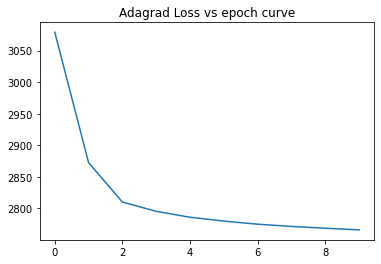

In [0]:
plt.title('Adagrad Loss vs epoch curve')
plt.plot(loss_epoch)

1 d) Training using RMSprop optimizer

In [0]:
def rmsprop(param, sqr, lr, gamma, batch_size):
    eps_stable = 1e-8
    g = param.grad / batch_size
    sqr[:] = gamma * sqr + (1. - gamma) * g**2
    div = lr * g / torch.sqrt(sqr + eps_stable)
    return param-div

learning_rate = 0.002
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()

sqrs = []
vs = []
model = model.to(device)
for parameter in model.parameters():
  sqrs.append(torch.zeros(parameter.shape).to(device))
  vs.append(torch.zeros(parameter.shape).to(device))
criterion = nn.CrossEntropyLoss()
parameters = model.parameters()

loss_epoch = []
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          for parameter,sqr in zip(model.parameters(),sqrs):
            new_param = rmsprop(parameter,sqr,learning_rate,0.8,BATCH_SIZE)
            parameter.copy_(new_param)

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    loss_epoch.append(train_running_loss)
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.5809 | Train Accuracy: 88.45
Epoch: 1 | Loss: 1.5198 | Train Accuracy: 94.28
Epoch: 2 | Loss: 1.5064 | Train Accuracy: 95.65
Epoch: 3 | Loss: 1.4978 | Train Accuracy: 96.50
Epoch: 4 | Loss: 1.4904 | Train Accuracy: 97.26
Epoch: 5 | Loss: 1.4847 | Train Accuracy: 97.85
Epoch: 6 | Loss: 1.4807 | Train Accuracy: 98.23
Epoch: 7 | Loss: 1.4777 | Train Accuracy: 98.55
Epoch: 8 | Loss: 1.4757 | Train Accuracy: 98.75
Epoch: 9 | Loss: 1.4738 | Train Accuracy: 98.92


In [0]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy for RMSProp optimizer: %.2f'%( test_acc/i))

Test Accuracy for RMSProp optimizer: 98.14


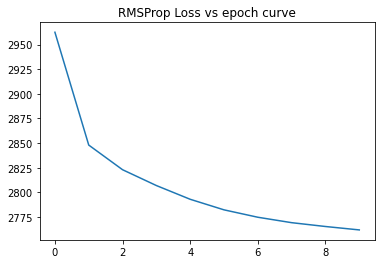

In [0]:
plt.title('RMSProp Loss vs epoch curve')
plt.plot(loss_epoch)

1 e) Using Adam optimizer

In [0]:
def adam(param, v, sqr, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    g = param.grad / batch_size
    v[:] = beta1 * v + (1. - beta1) * g
    sqr[:] = beta2 * sqr + (1. - beta2) * g**2
    v_bias_corr = v / (1. - beta1 ** t)
    sqr_bias_corr = sqr / (1. - beta2 ** t)
    div = lr * v_bias_corr / (torch.sqrt(sqr_bias_corr) + eps_stable)
    return param-div

learning_rate = 0.002
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()

sqrs = []
vs = []
model = model.to(device)
for parameter in model.parameters():
  sqrs.append(torch.zeros(parameter.shape).to(device))
  vs.append(torch.zeros(parameter.shape).to(device))
criterion = nn.CrossEntropyLoss()
parameters = model.parameters()

loss_epoch = []
t = 0
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()

        t += 1
        with torch.no_grad():
          for parameter,sqr,v in zip(model.parameters(),sqrs,vs):
            new_param = adam(parameter,v,sqr,learning_rate,BATCH_SIZE,t)
            parameter.copy_(new_param)

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    loss_epoch.append(train_running_loss)
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 2.1731 | Train Accuracy: 28.86
Epoch: 1 | Loss: 1.5973 | Train Accuracy: 86.52
Epoch: 2 | Loss: 1.4914 | Train Accuracy: 97.16
Epoch: 3 | Loss: 1.4844 | Train Accuracy: 97.83
Epoch: 4 | Loss: 1.4806 | Train Accuracy: 98.21
Epoch: 5 | Loss: 1.4784 | Train Accuracy: 98.41
Epoch: 6 | Loss: 1.4769 | Train Accuracy: 98.56
Epoch: 7 | Loss: 1.4761 | Train Accuracy: 98.63
Epoch: 8 | Loss: 1.4747 | Train Accuracy: 98.79
Epoch: 9 | Loss: 1.4741 | Train Accuracy: 98.83


In [0]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy for Adam optimizer: %.2f'%( test_acc/i))

Test Accuracy for Adam optimizer: 98.32


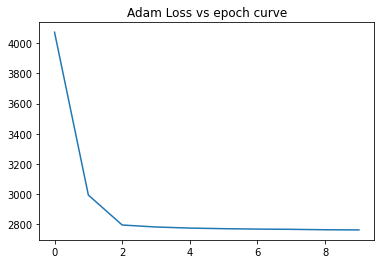

In [0]:
plt.title('Adam Loss vs epoch curve')
plt.plot(loss_epoch)

2b) 8 Layer network with no Batch normalization

In [0]:
class MyModelLarge(nn.Module):
    def __init__(self):
        super(MyModelLarge, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(32*16*16,128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        
        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [0]:
def adam(param, v, sqr, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    g = param.grad / batch_size
    v[:] = beta1 * v + (1. - beta1) * g
    sqr[:] = beta2 * sqr + (1. - beta2) * g**2
    v_bias_corr = v / (1. - beta1 ** t)
    sqr_bias_corr = sqr / (1. - beta2 ** t)
    div = lr * v_bias_corr / (torch.sqrt(sqr_bias_corr) + eps_stable)
    return param-div

learning_rate = 1e-4
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModelLarge()

sqrs = []
vs = []
model = model.to(device)
for parameter in model.parameters():
  sqrs.append(torch.zeros(parameter.shape).to(device))
  vs.append(torch.zeros(parameter.shape).to(device))
criterion = nn.CrossEntropyLoss()
parameters = model.parameters()

loss_epoch = []
t = 0
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()
    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()

        t += 1
        with torch.no_grad():
          for parameter,sqr,v in zip(model.parameters(),sqrs,vs):
            new_param = adam(parameter,v,sqr,learning_rate,BATCH_SIZE,t)
            parameter.copy_(new_param)

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    loss_epoch.append(train_running_loss)
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy for Adam optimizer: %.2f'%( test_acc/i))

Epoch: 0 | Loss: 1.6905 | Train Accuracy: 77.29
Epoch: 1 | Loss: 1.5127 | Train Accuracy: 95.09
Epoch: 2 | Loss: 1.4927 | Train Accuracy: 97.02
Epoch: 3 | Loss: 1.4860 | Train Accuracy: 97.69
Epoch: 4 | Loss: 1.4838 | Train Accuracy: 97.88
Epoch: 5 | Loss: 1.4810 | Train Accuracy: 98.17
Epoch: 6 | Loss: 1.4788 | Train Accuracy: 98.37
Epoch: 7 | Loss: 1.4773 | Train Accuracy: 98.54
Epoch: 8 | Loss: 1.4772 | Train Accuracy: 98.53
Epoch: 9 | Loss: 1.4754 | Train Accuracy: 98.72
Test Accuracy for Adam optimizer: 98.22


Network with batch normalization

In [0]:
class MyModelLarge(nn.Module):
    def __init__(self):
        super(MyModelLarge, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.d1 = nn.Linear(32*16*16,128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(self.conv3(x))
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        
        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        # flatten => 32 x (32*26*26)
        return out

In [0]:
def adam(param, v, sqr, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    g = param.grad / batch_size
    v[:] = beta1 * v + (1. - beta1) * g
    sqr[:] = beta2 * sqr + (1. - beta2) * g**2
    v_bias_corr = v / (1. - beta1 ** t)
    sqr_bias_corr = sqr / (1. - beta2 ** t)
    div = lr * v_bias_corr / (torch.sqrt(sqr_bias_corr) + eps_stable)
    return param-div

learning_rate = 1e-4
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModelLarge()

sqrs = []
vs = []
model = model.to(device)
for parameter in model.parameters():
  sqrs.append(torch.zeros(parameter.shape).to(device))
  vs.append(torch.zeros(parameter.shape).to(device))
criterion = nn.CrossEntropyLoss()
parameters = model.parameters()

loss_epoch = []
t = 0
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()
    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()

        t += 1
        with torch.no_grad():
          for parameter,sqr,v in zip(model.parameters(),sqrs,vs):
            new_param = adam(parameter,v,sqr,learning_rate,BATCH_SIZE,t)
            parameter.copy_(new_param)

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    loss_epoch.append(train_running_loss)
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy for Adam optimizer: %.2f'%( test_acc/i))



Epoch: 0 | Loss: 1.7184 | Train Accuracy: 74.46
Epoch: 1 | Loss: 1.5263 | Train Accuracy: 93.67
Epoch: 2 | Loss: 1.4817 | Train Accuracy: 98.11
Epoch: 3 | Loss: 1.4791 | Train Accuracy: 98.38
Epoch: 4 | Loss: 1.4760 | Train Accuracy: 98.69
Epoch: 5 | Loss: 1.4752 | Train Accuracy: 98.75
Epoch: 6 | Loss: 1.4746 | Train Accuracy: 98.79
Epoch: 7 | Loss: 1.4733 | Train Accuracy: 98.94
Epoch: 8 | Loss: 1.4728 | Train Accuracy: 98.97
Epoch: 9 | Loss: 1.4721 | Train Accuracy: 99.06
Test Accuracy for Adam optimizer: 98.99


2c. Network with dropout

In [0]:
class MyModelLarge(nn.Module):
    def __init__(self):
        super(MyModelLarge, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(32*16*16,128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.dropout(x,p=0.5)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        # flatten => 32 x (32*26*26)
        return out

In [0]:
def adam(param, v, sqr, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    g = param.grad / batch_size
    v[:] = beta1 * v + (1. - beta1) * g
    sqr[:] = beta2 * sqr + (1. - beta2) * g**2
    v_bias_corr = v / (1. - beta1 ** t)
    sqr_bias_corr = sqr / (1. - beta2 ** t)
    div = lr * v_bias_corr / (torch.sqrt(sqr_bias_corr) + eps_stable)
    return param-div

learning_rate = 1e-4
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModelLarge()

sqrs = []
vs = []
model = model.to(device)
for parameter in model.parameters():
  sqrs.append(torch.zeros(parameter.shape).to(device))
  vs.append(torch.zeros(parameter.shape).to(device))
criterion = nn.CrossEntropyLoss()
parameters = model.parameters()

loss_epoch = []
t = 0
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()
    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()

        t += 1
        with torch.no_grad():
          for parameter,sqr,v in zip(model.parameters(),sqrs,vs):
            new_param = adam(parameter,v,sqr,learning_rate,BATCH_SIZE,t)
            parameter.copy_(new_param)

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    loss_epoch.append(train_running_loss)
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy for Adam optimizer: %.2f'%( test_acc/i))



Epoch: 0 | Loss: 1.7510 | Train Accuracy: 71.10
Epoch: 1 | Loss: 1.5047 | Train Accuracy: 95.85
Epoch: 2 | Loss: 1.4922 | Train Accuracy: 97.05
Epoch: 3 | Loss: 1.4871 | Train Accuracy: 97.56
Epoch: 4 | Loss: 1.4844 | Train Accuracy: 97.80
Epoch: 5 | Loss: 1.4807 | Train Accuracy: 98.18
Epoch: 6 | Loss: 1.4789 | Train Accuracy: 98.37
Epoch: 7 | Loss: 1.4776 | Train Accuracy: 98.49
Epoch: 8 | Loss: 1.4765 | Train Accuracy: 98.60
Epoch: 9 | Loss: 1.4753 | Train Accuracy: 98.71
Epoch: 10 | Loss: 1.4743 | Train Accuracy: 98.82
Epoch: 11 | Loss: 1.4743 | Train Accuracy: 98.81
Epoch: 12 | Loss: 1.4733 | Train Accuracy: 98.93
Epoch: 13 | Loss: 1.4727 | Train Accuracy: 98.98
Epoch: 14 | Loss: 1.4721 | Train Accuracy: 99.03
Epoch: 15 | Loss: 1.4723 | Train Accuracy: 99.02
Epoch: 16 | Loss: 1.4713 | Train Accuracy: 99.12
Epoch: 17 | Loss: 1.4708 | Train Accuracy: 99.17
Epoch: 18 | Loss: 1.4702 | Train Accuracy: 99.21
Epoch: 19 | Loss: 1.4706 | Train Accuracy: 99.19
Test Accuracy for Adam optimiz